>### 🚩 *Create a free WhyLabs account to complete this example!*<br>
>*Did you know you can store, visualize, and monitor whylogs profiles with the [WhyLabs Observability Platform](https://whylabs.ai/whylabs-free-sign-up?utm_source=github&utm_medium=referral&utm_campaign=langkit)? Sign up for a [free WhyLabs account](https://whylabs.ai/whylogs-free-signup?utm_source=github&utm_medium=referral&utm_campaign=LLM_to_WhyLabs) to leverage the power of whylogs and WhyLabs together!*

# How to create custom metrics for monitoring LLMs at scale

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/whylabs/whylabs-tutorials/logging_data/text/Custom_LangKit_metrics_tutorial.ipynb)



Contents:
1. Intro to LangKit
2. Creating a custom metric in LangKit
3. Sharing new metrics with the community

# 1. Intro to LangKit

LangKit is an open-source text metrics toolkit for monitoring language models. It offers an array of methods for extracting relevant signals from the input and/or output text, which are compatible with the open-source data logging library [whylogs](https://github.com/whylabs/whylogs). Productionizing language models, including LLMs, comes with a range of risks due to the infinite amount of input combinations, which can elicit an infinite amount of outputs. The unstructured nature of text poses a challenge in the ML observability space - a challenge worth solving, since the lack of visibility on the model's behavior can have serious consequences.

💡 Want to experience LangKit? Go to this [notebook](https://github.com/whylabs/langkit/blob/main/langkit/examples/Intro_to_Langkit.ipynb)!

LangKit is a suite of user defined functions (UDFs) that whylogs applies to the prompts and responses processed by a language model in order to monitor metrics measuring text quality, relevance, security, sentiment, etc. This tutorial covers how to add a custom metric to LangKit. Let's start by installing whylogs:

In [ ]:
# Note: you may need to restart the kernel to use updated packages.
%pip install -U langkit[all] -qq
%pip install xformers ipywidgets -qq

Let's cover some basic whylogs and LangKit concepts we'll need before diving into building the custom metric. You can find more in-depth documentation about whylogs [here](https://github.com/whylabs/whylogs/tree/mainline/python/examples) and about LangKit [here](https://github.com/whylabs/langkit/tree/main#readme).

## whylogs

whylogs **profiles** are the core of the whylogs library. They capture key statistical properties of data **logged** via whylogs, such as the distribution (far beyond simple mean, median, and standard deviation measures), the number of missing values, and a wide range of configurable custom metrics. By capturing these summary statistics, we are able to accurately represent the data, detect changes in the data over time, and monitor data quality. The data logged can be represented as either a Pandas `DataFrame`, or a single row of data represented as a Python dictionary mapping the column name (stirng) to a the value of that column in the row.

A configurable **dataset schema** determines which statistics whylogs tracks for each column of the logged dataset. Schemas are passed to the whylogs' `log()` function as an optional argument. The schema also specifies the UDFs used to generate additional columns to log. Since the default whylogs schema doesn't track statistics that are very interesting for monitoring language models, LangKit provides a sutie of UDFs tailored for this application.

## LangKit

As noted above, LangKit provies a sutie of UDFs for monitoring language models. The Langkit functions `langkit.all_metrics.init()`, `langkit.llm_metrics.init()`, and `langkit.light_metrics.init()` return whylogs schemas that invoke all the LangKit UDFs, just the UDFs recommended for monitoring LLMs, and just a few light-weight metrics respectively. (Note: there's an unfortuante vocabulary inconsitency---what LangKit refers to as a "metric" is more like a column in whylogs. A whylogs metric refers to a statistic that's tracked for a column.)  You can also import the specific LangKit modules that define the UDFs you want to use and call `whylogs.experimental.core.udf_schema.udf_schema()` to produce a schema with just those UDFs.

The LangKit schemas assume the language model input is in a column named "prompt" and the output is in a column named "response." The `langkit.LangKitConfig` class holds the column names and other LangKit parameters. The LangKit UDFs take one of both of those columns as input and produce additional columns to log as output. whylogs tracks the relevant statistics of the UDF output columns.

# 2. Creating a custom metric in LangKit

### Use case: Malicious code detection

In this tutorial we'll implement a custom metric for detecting whether the prompt contains malicious code that may pose a threat to software systems.

For this task we'll use an open source model from the HuggingFace repository available [here](https://huggingface.co/mrm8488/codebert-base-finetuned-detect-insecure-code).
It's a binary classification model with an output layer of size 2, where the first value represents the probability of secure code and the second one of insecure code.


In [1]:
%pip install transformers -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.1 MB/s eta 0:00:00


In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

tokenizer = AutoTokenizer.from_pretrained('mrm8488/codebert-base-finetuned-detect-insecure-code')
model = AutoModelForSequenceClassification.from_pretrained('mrm8488/codebert-base-finetuned-detect-insecure-code')

Let's run a single prediction outside of LangKit to check if the model works as expected.

In [3]:
insecure_code_example = """static int r3d_read_rdvo(AVFormatContext *s, Atom *atom)\n\n{\n\n    R3DContext *r3d = s->priv_data;\n\n    AVStream *st = s->streams[0];\n\n    int i;\n\n\n\n    r3d->video_offsets_count = (atom->size - 8) / 4;\n\n    r3d->video_offsets = av_malloc(atom->size);\n\n    if (!r3d->video_offsets)\n\n        return AVERROR(ENOMEM);\n\n\n\n    for (i = 0; i < r3d->video_offsets_count; i++) {\n\n        r3d->video_offsets[i] = avio_rb32(s->pb);\n\n        if (!r3d->video_offsets[i]) {\n\n            r3d->video_offsets_count = i;\n\n            break;\n\n        }\n\n        av_dlog(s, "video offset %d: %#x\\n", i, r3d->video_offsets[i]);\n\n    }\n\n\n\n    if (st->r_frame_rate.num)\n\n        st->duration = av_rescale_q(r3d->video_offsets_count,\n\n                                    (AVRational){st->r_frame_rate.den,\n\n                                                 st->r_frame_rate.num},\n\n                                    st->time_base);\n\n    av_dlog(s, "duration %"PRId64"\\n", st->duration);\n\n\n\n    return 0;\n\n}\n"""

In [4]:
sqli_example = "SELECT * FROM Users WHERE ((Username='$username') AND (Password=MD5('$password')))"

inputs = tokenizer(insecure_code_example, return_tensors="pt", truncation=True, padding='max_length')
labels = torch.tensor([1]).unsqueeze(0)  # Batch size 1
outputs = model(**inputs, labels=labels)
loss = outputs.loss
logits = outputs.logits
probs = torch.nn.functional.softmax(outputs.logits, dim=1)
probs

tensor([[6.5826e-04, 9.9934e-01]], grad_fn=<SoftmaxBackward0>)

### Registering the new metric in LangKit

In [5]:
%pip install whylogs
%pip install langkit[all]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 403.0/403.0 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.3/547.3 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 747.9/747.9 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.7 MB/s eta 0:00

In [19]:
from typing import List, Dict, Union
from whylogs.experimental.core.udf_schema import register_dataset_udf
from whylogs.core.stubs import np
import random
import pandas as pd
from whylogs.core.datatypes import String


@register_dataset_udf(["prompt"], udf_name="prompt.insecure_code")
def insecure_code_score(text: Union[Dict[str, List], pd.DataFrame]) -> Union[List, pd.Series]:
    insecure_code_scores: List[int] = []
    for prompt in text["prompt"]:
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, padding='max_length')
        labels = torch.tensor([1]).unsqueeze(0)  # Batch size 1
        outputs = model(**inputs, labels=labels)
        # apply a softmax to convert logits into a probability distribution
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        # get the probability of insecure code
        insecure_code_score = probs.detach().numpy().squeeze()[1]
        insecure_code_scores.append(insecure_code_score)
    return insecure_code_scores

Now all we need to do is instantiate the LLM metrics schema.

Thanks to the `@register_dataset_udf` decorator the `insecure_code_score()` function will automatically be included in the set of metrics to be extracted from the profiled prompts.

Note: `llm_metrics.init()` downloads all the relevant resources like models, so this is slow first time.

In [20]:
from langkit import llm_metrics

schema = llm_metrics.init()

### Profiling the data

Let's get some data to extract the LLM metrics from.

We'll use a sample provided by whylogs for convenience. Feel free to plug in your own dataset here!

In [21]:
import whylogs as why
from langkit.whylogs.samples import load_chats, show_first_chat

chats = load_chats()
chats.head()

,prompt,response
0,"Hello,",World!
1,"Hello, World!",Hello! How can I assist you today?
2,Aproximately how many atoms are in the known u...,There are approximately 10^80 atoms in the obs...
3,What is the speed of light in m/s? Can you out...,The speed of light in a vacuum is approximatel...
4,How many digits are in a Discover credit card ...,A Discover credit card number has 16 digits. T...


We're all set and ready to profile our prompts and responses:

In [22]:
# initializing an anonymous WhyLabs session to get a link to the platform
why.init(session_type='whylabs_anonymous')

# data profiling
results = why.log(chats, name="langkit-sample-chats-all", schema=schema)

✅ Aggregated 50 rows into profile 'langkit-sample-chats-all'

Visualize and explore this profile with one-click
🔍 https://hub.whylabsapp.com/resources/model-1/profiles?profile=ref-w4cibZgox43t2UZJ&sessionToken=session-3ENyCEUW


### Inspecting the profiles

After logging the data, we can inspect the profile including our custom metric in the WhyLabs platform by clicking on the link above.

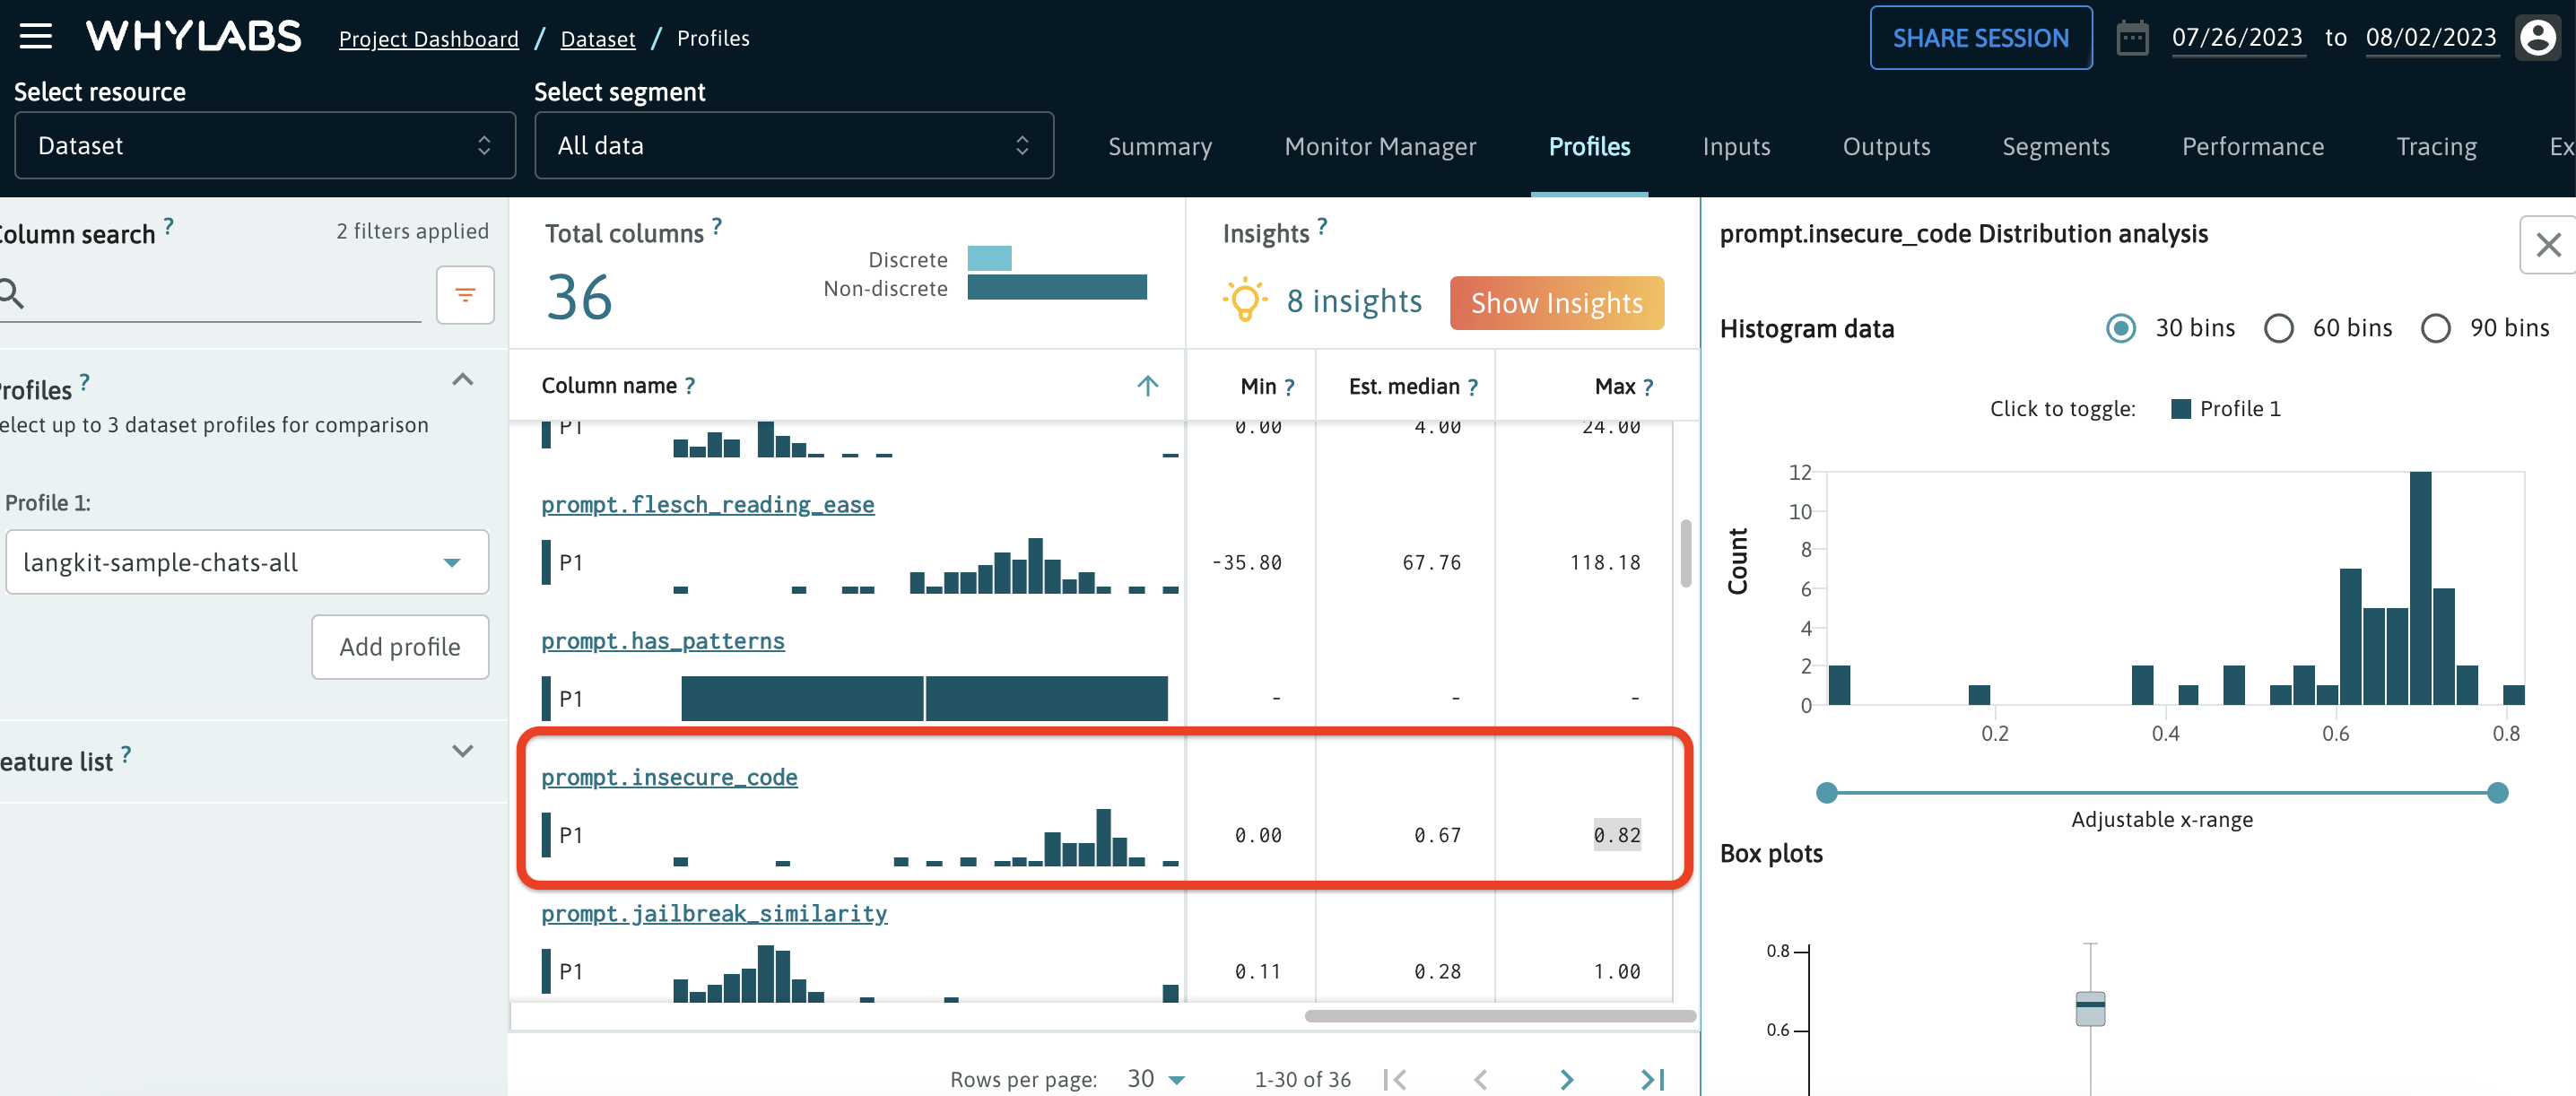

We can also convert our metric into a Python dictionary or a pandas `DataFrame` and analyze it programmatically. Here's how to do that:

In [23]:
prompt_summary = results.view().get_column("prompt.insecure_code").to_summary_dict()
for key, value in prompt_summary.items():
    print(f"{key}: {value}")

counts/n: 50
counts/null: 0
counts/nan: 0
counts/inf: 0
types/integral: 0
types/fractional: 50
types/boolean: 0
types/string: 0
types/object: 0
types/tensor: 0
distribution/mean: 0.3886935132741928
distribution/stddev: 0.16938666202884442
distribution/n: 50
distribution/max: 0.9982861876487732
distribution/min: 0.17789603769779205
distribution/q_01: 0.17789603769779205
distribution/q_05: 0.25310319662094116
distribution/q_10: 0.271707683801651
distribution/q_25: 0.2988153398036957
distribution/median: 0.33942344784736633
distribution/q_75: 0.3852780759334564
distribution/q_90: 0.6407937407493591
distribution/q_95: 0.8117023706436157
distribution/q_99: 0.9982861876487732
cardinality/est: 47.00000536938579
cardinality/upper_1: 47.002352044432925
cardinality/lower_1: 47.0


### Next steps

Having uploaded the profiles to the WhyLabs platform **we can start monitoring various metrics provided by LangKit** covering such crucial aspects of LLM-based applications such as readability, sentiment, risk of prompt injections - and your own custom metric! This way we can conveniently observe our data patterns, draw insights and apply continuous validation.

Please refer to [this  documentation page](https://docs.whylabs.ai/docs/monitor-manager) to learn how to set up the monitors!

# 3. Sharing new metrics with the community

If you've written an interesting metric, consider sharing it with the LangKit community!

## Contribution Process

First, ensure you have permission to distribute your code & intellectual property under LangKit's [Apache 2.0 license](http://www.apache.org/licenses/). Next, open a [GitHub pull request](https://github.com/whylabs/langkit/pulls) with your contribution on a branch. Name your branchp something like `dev/<your name>/<metric name>`. Address any feedback from code reviews by WhyLabs engineers, and when it's ready WhyLabs engineers will merge and release your pull request.

Assuming you have git configured, you'd do something like:

```
git clone https://github.com/whylabs/langkit.git
cd langkit
poetry install -E all
git branch dev/my-name/my-metric
git checkout dev/my-name/my-metric
# edit source code
poetry run pytest tests
git commit -am "Add my cool new metric"
git push --set-upstream origin dev/my-name/my-metric
```

## Where to Add Your Code

LangKit has a number of modules that contain one or more UDFs that implement metrics on related themes, e.g., text quality, security, sentiment, etc. If your new metric is related to one of these themes, you should add it to the corresponding module. If your metric is unrelated to the existing modules, you can create a new module to house your metric(s). We'll work through an example of how to do this for the insecure code detector below.

### LangKit modules

The modules source files are located in the `langkit` subdirectory
*   `injections.py` for monitoring prompt injection
*   `input_output.py` for monitoring relevance
*   `sentiment.py` for monitoring sentiment
*   `textstats.py` for monitoring text statistics like readability, reading level, word counts, etc.  # or is this just the teststat integration?
*   `themes.py` for monitoring jailbreaks and refusals
*   `topics.py` for monitoring topic classification
*   `toxicity.py` for monitoring toxicity

Be sure to write unit tests under `langkit/tests`.

### How to add a new module

Let's create an `insecure_code.py` module for our new metric. See the comments in the code for implementation details.

In [ ]:
# langkit/langkit/insecure_code.py

from typing import List, Dict, Union
from whylogs.core.stubs import np
from whylogs.experimental.core.udf_schema import register_dataset_udf
from . import LangKitConfig
import random
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# LangKitConfig contains LangKit's configuration parameters. Here we
# grab the name of the prompt column

_lang_config = LangKitConfig()
_prompt: str = _lang_config.prompt_column
_insecure_code_model = None
_insecure_code_tokenizer = None


# Modules register one or more UDFs that implement their metrics.
# TODO: See URL for UDF documentation

@register_dataset_udf([_prompt], udf_name="prompt.insecure_code")
def insecure_code_score(text: Union[Dict[str, List], pd.DataFrame]) -> Union[List, pd.Series]:
    insecure_code_scores: List[int] = []
    for prompt in text[_prompt]:
        inputs = _insecure_code_tokenizer(prompt, return_tensors="pt", truncation=True, padding='max_length')
        labels = torch.tensor([1]).unsqueeze(0)  # Batch size 1
        outputs = _insecure_code_model(**inputs, labels=labels)
        # apply a softmax to convert logits into a probability distribution
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        # get the probability of insecure code
        insecure_code_score = probs.detach().numpy().squeeze()[1]
        insecure_code_scores.append(insecure_code_score)
    return insecure_code_scores


# The init() function can download model parameters or do other module setup
# LangKit modules can have state. It will be initialized by calling the
# module's init() function. Here we'll load the model and tokenizer needed for
# the insecure code detection task

def init():

    global _insecure_code_model
    global _insecure_code_tokenizer
    _insecure_code_tokenizer = AutoTokenizer.from_pretrained(_lang_config.insecure_code_model)
    _insecure_code_model = AutoModelForSequenceClassification.from_pretrained(_lang_config.insecure_code_model)


# The init() function is run on module import so that the UDFs are ready to run

init()

Writing /usr/local/lib/python3.10/dist-packages/langkit/insecure_code.py


Let's add our tokenizer and classifier names to the `LangKitConfig` object.

In [ ]:
# langkit/langkit/__init__.py

...

@dataclass
class LangKitConfig:
    pattern_file_path: str = pkg_resources.resource_filename(
        __name__, "pattern_groups.json"
    )
    # parameters for our new metric
    insecure_code_model: str = "mrm8488/codebert-base-finetuned-detect-insecure-code"

    transformer_name: str = "sentence-transformers/all-MiniLM-L6-v2"
    theme_file_path: str = pkg_resources.resource_filename(__name__, "themes.json")
    prompt_column: str = "prompt"
    response_column: str = "response"
    topics: list = field(
        default_factory=lambda: [
            "law",
            "finance",
            "medical",
            "education",
            "politics",
            "support",
        ]
    )
    nlp_scores: list = field(
        default_factory=lambda: [
            "bleu",
            "rouge",
            "meteor",
        ]
    )
    reference_corpus: str = ""


Now we need to add our module to `all_metrics.py` and `llm_metrics.py`. Let's pretend our `init()` function has to download a large classification model, so it's not appropriate to add it to `light_metrics.py`. But if your custom metric's initializaiton is quick, add it there too...

Add it to `all_metrics.py`

In [ ]:
# langkit/langkit/all_metrics.py
from whylogs.experimental.core.udf_schema import udf_schema
from whylogs.core.schema import DeclarativeSchema

from langkit import injections
from langkit import topics
from langkit import regexes
from langkit import sentiment
from langkit import insecure_code  # this is our new module
from langkit import textstat
from langkit import themes
from langkit import toxicity
from langkit import input_output


def init() -> DeclarativeSchema:
    injections.init()
    topics.init()
    regexes.init()
    sentiment.init()
    insecure_code.init()  # initialize our new module
    textstat.init()
    themes.init()
    toxicity.init()
    input_output.init()
    text_schema = udf_schema()
    return text_schema


And `llm_metrics.py` is similar.

In [ ]:
# langkit/langkit/llm_metrics.py
from logging import getLogger
from whylogs.experimental.core.udf_schema import udf_schema
from whylogs.core.schema import DeclarativeSchema

diagnostic_logger = getLogger(__name__)

try:
    from langkit import regexes
    from langkit import sentiment
    from langkit import insecure_code  # our new module
    from langkit import textstat
    from langkit import themes
    from langkit import toxicity
    from langkit import input_output
except ImportError:
    raise ImportError(
        "To use `llm_metrics` please install it with `pip install langkit[all]`."
    )


def init() -> DeclarativeSchema:
    regexes.init()
    sentiment.init()
    insecure_code.init()  # initialize our new moudle
    textstat.init()
    themes.init()
    toxicity.init()
    input_output.init()

    text_schema = udf_schema()
    return text_schema

Now LangKit users who invoke `all_metrics.init()` or `llm_metrics.init()` will get the insecure code metric.